In [177]:
# ! pip install av
# ! pip install ffmpeg-python
# ! pip install opencv-python
# ! pip install mediapipe
# ! pip install pandas
# ! pip install tqdm

# start


## import

In [178]:
import cv2 as cv
import mediapipe as mp
import pandas as pd
import os
import torch
from torch import tensor
import torch.nn as nn
from torch.nn import DataParallel
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import ffmpeg

# GPU

In [179]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    multi_gpu = True
else:
    multi_gpu = False
device , multi_gpu

Number of GPUs available: 4


(device(type='cuda', index=0), True)

## skeleton to csv

In [180]:
def skeleton_csv(video_path ='', output_video_path ='', make_video=True, output_video_name='skeleton_video'):
    try:
        # Initialize MediaPipe Pose
        mp_pose = mp.solutions.pose
        mp_drawing = mp.solutions.drawing_utils
        pose = mp_pose.Pose(static_image_mode=False, model_complexity=1, enable_segmentation=False, min_detection_confidence=0.5)

        cap = cv.VideoCapture(video_path)
        if not cap.isOpened():
            print("Error: Unable to open video file at path:", video_path)
            return None
        all_landmarks = []

        # Get video properties for output video
        frame_width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv.CAP_PROP_FPS)

        # Define the codec and create VideoWriter object
        out = None
        if make_video:
            output_video_name = output_video_name + '.mp4'
            output_video_path = os.path.join(output_video_path, output_video_name)
            out = cv.VideoWriter(output_video_path, cv.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

        while cap.isOpened():
            success, image = cap.read()
            if not success:
                break

            image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
            results = pose.process(image_rgb)

            if results.pose_landmarks:
                # Draw the pose annotation on the image
                mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

                # Extract and store landmarks
                ref_x = (results.pose_landmarks.landmark[23].x + results.pose_landmarks.landmark[24].x) / 2
                ref_y = (results.pose_landmarks.landmark[23].y + results.pose_landmarks.landmark[24].y) / 2
                ref_z = (results.pose_landmarks.landmark[23].z + results.pose_landmarks.landmark[24].z) / 2

                landmarks = []
                for lm in results.pose_landmarks.landmark:
                    rel_x, rel_y, rel_z = lm.x - ref_x, lm.y - ref_y, lm.z - ref_z
                    landmarks.extend([rel_x, rel_y, rel_z, lm.visibility])
                all_landmarks.append(landmarks)

                if make_video:
                    out.write(image)  # Write the frame with pose to the output video

        cap.release()
        if make_video:
            out.release()

        df = pd.DataFrame(all_landmarks)

        #return df
        skeletons_tensor = torch.tensor(all_landmarks, dtype=torch.float32)
        print(skeletons_tensor.shape)
        return skeletons_tensor
    except:
        return torch.Tensor([1])  # 오류 발생 시 기본 텐서 반환


In [181]:
def skeleton_csv90frames(video_path='', output_video_path='', make_video=True, output_video_name='skeleton_video'):

    
    # try:
    #     ffmpeg.probe(video_path)
    # except:
    #     print(f"FFmpeg error for file {video_path}: {e.stderr}")
    #     return torch.Tensor([1])  # Return a default tensor if FFmpeg cannot read the file


    # Initialize MediaPipe Pose
    mp_pose = mp.solutions.pose
    mp_drawing = mp.solutions.drawing_utils
    pose = mp_pose.Pose(static_image_mode=False, model_complexity=1, enable_segmentation=False, min_detection_confidence=0.5)

    cap = cv.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Unable to open video file at path:", video_path)
        return torch.Tensor([1]) # prevent from None going in to dataset (if not, learning stops)
    all_landmarks = []

    # Get video properties for output video
    frame_width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv.CAP_PROP_FPS)

    # Define the codec and create VideoWriter object
    out = None
    if make_video: 
        output_video_name = output_video_name + '.mp4'
        output_video_path = os.path.join(output_video_path, output_video_name)
        out = cv.VideoWriter(output_video_path, cv.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

    frame_count = 0
    max_frames = 30  # Process only first 90 frames

    while cap.isOpened() and frame_count < max_frames:
        success, image = cap.read()
        if not success:
            break

        image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        results = pose.process(image_rgb)

        if results.pose_landmarks:
            # Draw the pose annotation on the image
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            # Extract and store landmarks
            ref_x = (results.pose_landmarks.landmark[23].x + results.pose_landmarks.landmark[24].x) / 2
            ref_y = (results.pose_landmarks.landmark[23].y + results.pose_landmarks.landmark[24].y) / 2
            ref_z = (results.pose_landmarks.landmark[23].z + results.pose_landmarks.landmark[24].z) / 2

            landmarks = []
            for lm in results.pose_landmarks.landmark:
                rel_x, rel_y, rel_z = lm.x - ref_x, lm.y - ref_y, lm.z - ref_z
                landmarks.extend([rel_x, rel_y, rel_z, lm.visibility])
            all_landmarks.append(landmarks)

            if make_video:
                out.write(image)  # Write the frame with pose to the output video

        frame_count += 1  # Increment frame count

    cap.release()
    if make_video:
        out.release()


    skeletons_tensor = torch.tensor(all_landmarks, dtype=torch.float32)
    if skeletons_tensor is None:
        skeletons_tensor = torch.Tensor([1]) # Prevent from None type return
    return skeletons_tensor



# Model

In [182]:
# class LSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, num_classes):
#         super(LSTMModel, self).__init__()
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, num_classes)

#     def forward(self, x):
#         out, _ = self.lstm(x)
#         out = self.fc(out[:, -1, :])
#         return out

In [183]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.5):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, bidirectional=True, dropout=dropout_rate)
        self.layer_norm = nn.LayerNorm(hidden_size * 2)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.layer_norm(out[:, -1, :])
        out = self.dropout(out)
        out = self.fc(out)
        return out


# Get dataset - video

In [184]:
class UCF4Dataset(Dataset):
    def __init__(self, directory):
        ds_store_path = os.path.join(directory, '.DS_Store')
        if os.path.exists(ds_store_path):
            os.remove(ds_store_path)
        self.directory = directory
        self.classes = os.listdir(directory)
        self.data = []

        # ignore ._ files  (Mac os system folder)
        for class_name in self.classes:
            class_path = os.path.join(directory, class_name)
            for video in os.listdir(class_path):
                if not video.startswith('.'):
                    self.data.append((os.path.join(class_path, video), class_name))
        print(self.classes)
        print(len(self.classes))
        # MediaPipe 초기화
        self.mp_pose = mp.solutions.pose
        self.pose = self.mp_pose.Pose(static_image_mode=False, model_complexity=1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_path, class_name = self.data[idx]
        skeletons = skeleton_csv(video_path=video_path,make_video=False)

        label = self.classes.index(class_name)
        return skeletons, label

## Function simplifyer

In [185]:
def extract_skeleton(video_path, pose):
    try:
        cap = cv.VideoCapture(video_path)
        if not cap.isOpened():
            print("비디오 파일을 열 수 없습니다:", video_path)
            return None

        all_landmarks = []
        while cap.isOpened():
            success, image = cap.read()
            if not success:
                break

            image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
            results = pose.process(image_rgb)

            if results.pose_landmarks:
                landmarks = []
                for lm in results.pose_landmarks.landmark:
                    landmarks.extend([lm.x, lm.y, lm.z, lm.visibility])
                all_landmarks.append(landmarks)

        cap.release()
        return all_landmarks
    except:
        print(f'error [extract skel] {video_path}')
        return torch.tensor([1.0, 1.0], dtype=torch.float32)

In [186]:
def convert_to_relative_position(all_landmarks):
    for landmarks in all_landmarks:
        # 여기서는 예를 들어 힙 중심을 기준으로 상대적 위치를 계산합니다.
        ref_x = (landmarks[23*4] + landmarks[24*4]) / 2
        ref_y = (landmarks[23*4+1] + landmarks[24*4+1]) / 2
        ref_z = (landmarks[23*4+2] + landmarks[24*4+2]) / 2

        for i in range(0, len(landmarks), 4):
            landmarks[i] -= ref_x
            landmarks[i+1] -= ref_y
            landmarks[i+2] -= ref_z

    return all_landmarks

In [187]:
def save_to_csv(all_landmarks, output_csv_path):
    try:
        df = pd.DataFrame(all_landmarks)
        df.to_csv(output_csv_path, index=False)
    except:
        print(f'error [save to csv] {output_csv_path}')

In [188]:
def create_skeleton_video(video_path, output_video_path, pose):
    # mp_drawing 모듈 로드
    mp_drawing = mp.solutions.drawing_utils

    cap = cv.VideoCapture(video_path)
    if not cap.isOpened():
        print("비디오 파일을 열 수 없습니다:", video_path)
        return

    frame_width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv.CAP_PROP_FPS)

    out = cv.VideoWriter(output_video_path, cv.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

    while cap.isOpened():
        success, image = cap.read()
        if not success:
            break

        image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        results = pose.process(image_rgb)

        if results.pose_landmarks:
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp.solutions.pose.POSE_CONNECTIONS)

        out.write(image)

    cap.release()
    out.release()

In [189]:
class UCF4Dataset_output_video(Dataset):
    def __init__(self, directory):
        # define your self
        #self.output_base_path = '..\\data\\UCF101\\UCF-101_outputvideo' #'..\\data\\UCF101\\UCF-101
        self.output_base_path = '..\\data\\UCF7' #'..\\data\\UCF101\\UCF-101
        self.create_skeleton_video = 0




        #init
        self.current_epoch = 0
        # MediaPipe 초기화
        self.mp_pose = mp.solutions.pose
        self.pose = self.mp_pose.Pose(
                                        static_image_mode=False,
                                        model_complexity=2,  # 최대 복잡도 설정
                                        smooth_landmarks=True
                                        )


        # data cleaning
        ds_store_path = os.path.join(directory, '.DS_Store')
        if os.path.exists(ds_store_path):
            os.remove(ds_store_path)
        self.directory = directory
        self.classes = os.listdir(directory)
        self.data = []
        

        # ignore ._ files  (Mac os system folder)
        for class_name in self.classes:
            class_path = os.path.join(directory, class_name)
            for video in os.listdir(class_path):
                if not video.startswith('.'):
                    if not video.startswith('.') and not video.endswith('.csv'):
                        self.data.append((os.path.join(class_path, video), class_name))

        print(self.classes)
        print(len(self.classes))

        
    def set_epoch(self, epoch):
        self.current_epoch = epoch

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_path, class_name = self.data[idx]

        # 원본 폴더 구조를 새로운 출력 폴더에 복제
        relative_path = os.path.relpath(video_path, self.directory)
        output_video_path = os.path.join(self.output_base_path, relative_path)
        
        output_video_dir = os.path.dirname(output_video_path)
        if not os.path.exists(output_video_dir):
            os.makedirs(output_video_dir)

        base_name = os.path.basename(video_path)
        name, _ = os.path.splitext(base_name)
        output_csv_name = f"{name}.csv"

        output_csv_full_path = os.path.join(output_video_dir, output_csv_name)

        if self.current_epoch == 0:
            all_landmarks = extract_skeleton(video_path, self.pose)
            # 상대 위치로 변환
            all_landmarks = convert_to_relative_position(all_landmarks)
            # CSV 파일 저장
            save_to_csv(all_landmarks, output_csv_full_path)
            #print(f'saved csv file : {output_csv_full_path}')
        else:
            try:
                # 두 번째 이후 에포크에서는 CSV 파일 사용
                df = pd.read_csv(output_csv_full_path)
                all_landmarks = df.values.tolist()
            except:
                print(f'get_item error [second epoch] {output_csv_full_path}')
                all_landmarks = [[1],[1]]

        # 텐서로 변환
        skeletons_tensor = torch.tensor(all_landmarks, dtype=torch.float32)

        label = self.classes.index(class_name)
        if skeletons_tensor is None:
            skeletons_tensor = torch.tensor([1.0, 1.0], dtype=torch.float32)
        return skeletons_tensor, label


## Use all dataset

In [190]:
# 데이터셋 및 데이터 로더 초기화
#dataset_path = '..\\data\\UCF101\\UCF4 small'  # 소규모 추출된 데이터셋의 경로
dataset_path = '..\\data\\UCF7' #all dataset!


#dataset = UCF4Dataset(dataset_path)
dataset = UCF4Dataset_output_video(dataset_path) # Output the video too

# 데이터셋 크기 정의
dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)  # 80%를 훈련 데이터로 사용
val_size = int(dataset_size * 0.10)  # 10%를 검증 데이터로 사용
test_size = dataset_size - train_size - val_size  # 나머지를 테스트 데이터로 사용

# Split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create Dataset
Batch_Size = 1
num_workers = 0

train_loader = DataLoader(train_dataset, batch_size=Batch_Size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=Batch_Size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=Batch_Size, shuffle=True, num_workers=num_workers)


['Biking', 'BoxingPunchingBag', 'BrushingTeeth', 'JugglingBalls', 'MoppingFloor', 'TennisSwing', 'WalkingWithDog']
7


## use only a few for example

In [191]:
# from torch.utils.data import DataLoader, random_split, Subset
# import random

# # 데이터셋 및 데이터 로더 초기화
# dataset_path = '..\\data\\UCF7' #all dataset!
# dataset = UCF4Dataset_output_video(dataset_path) # Output the video too

# # 데이터셋 크기 정의
# dataset_size = len(dataset)

# # 데이터셋의 10%만 사용
# subset_size = int(dataset_size * 0.05)
# subset_indices = random.sample(range(dataset_size), subset_size)
# subset_dataset = Subset(dataset, subset_indices)

# # 새로운 데이터셋 크기에 따라 훈련, 검증, 테스트 분할 비율 정의
# train_size = int(subset_size * 0.7)  # 70%를 훈련 데이터로 사용
# val_size = int(subset_size * 0.15)  # 15%를 검증 데이터로 사용
# test_size = subset_size - train_size - val_size  # 나머지를 테스트 데이터로 사용

# # Split
# train_dataset, val_dataset, test_dataset = random_split(subset_dataset, [train_size, val_size, test_size])

# # DataLoader 생성
# Batch_Size = 1
# num_workers = 0

# train_loader = DataLoader(train_dataset, batch_size=Batch_Size, shuffle=True, num_workers=num_workers)
# val_loader = DataLoader(val_dataset, batch_size=Batch_Size, shuffle=True, num_workers=num_workers)
# test_loader = DataLoader(test_dataset, batch_size=Batch_Size, shuffle=True, num_workers=num_workers)

In [192]:
len(train_loader),len(val_loader),len(test_loader)

(356, 44, 45)

# Parameter

In [193]:
# Define the LSTM model
input_size = 132  # Adjust based on your skeleton data
hidden_size = 128
num_layers = 5
num_classes = 4  # Adjust based on the number of classes in your dataset
num_classes = 101 # Base on UCF101 origianl
model = LSTMModel(input_size, hidden_size, num_layers, num_classes)
if multi_gpu:
    model = nn.DataParallel(model)
model.to(device)

DataParallel(
  (module): LSTMModel(
    (lstm): LSTM(132, 128, num_layers=5, batch_first=True, dropout=0.5, bidirectional=True)
    (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (fc): Linear(in_features=256, out_features=101, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [194]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.5, min_lr=0.0001)

In [195]:
# Initialize variables to track the best model
best_val_loss = float('inf')
best_model = None

# Trackers for graph
train_losses = []
val_losses = []

In [196]:
from tqdm import tqdm
# Training loop
num_epochs = 1000

for epoch in range(num_epochs):
    dataset.set_epoch(epoch)
    model.train()
    total_loss = 0
    for skeletons, labels in tqdm(train_loader):
        skeletons, labels = skeletons.to(device), labels.to(device)

        try:
            outputs = model(skeletons)
        except Exception as e:
            print(e)

        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # 검증 루프
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for skeletons, labels in val_loader:
            skeletons, labels = skeletons.to(device), labels.to(device)
            try:
                outputs = model(skeletons)
            except Exception as e:
                print(e)

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # 최고 모델 저장
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model = model.state_dict()
        print(f'----------------------saveed best model in epoch : {epoch} val loss : {avg_val_loss}---------------------------')

    scheduler.step(avg_val_loss)
    if epoch%100 == 0:

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')


# Save the best model
torch.save(best_model, '../OUTPUT/ucf101_model.pth')

100%|██████████| 356/356 [1:23:49<00:00, 14.13s/it]


----------------------saveed best model in epoch : 0 val loss : 1.5647608041763306---------------------------
Epoch [1/1000], Train Loss: 2.1577712372782525, Val Loss: 1.5647608041763306


100%|██████████| 356/356 [00:11<00:00, 30.38it/s]


----------------------saveed best model in epoch : 4 val loss : 1.487376227636229---------------------------


100%|██████████| 356/356 [00:11<00:00, 31.09it/s]


----------------------saveed best model in epoch : 5 val loss : 1.4618070582774552---------------------------


100%|██████████| 356/356 [00:11<00:00, 29.96it/s]


----------------------saveed best model in epoch : 6 val loss : 1.390790987421166---------------------------


100%|██████████| 356/356 [00:11<00:00, 30.08it/s]


----------------------saveed best model in epoch : 7 val loss : 1.3137750402092934---------------------------


100%|██████████| 356/356 [00:10<00:00, 32.48it/s]


----------------------saveed best model in epoch : 8 val loss : 1.2875023176046936---------------------------


100%|██████████| 356/356 [00:12<00:00, 29.50it/s]


----------------------saveed best model in epoch : 10 val loss : 1.2018907937136563---------------------------


100%|██████████| 356/356 [00:11<00:00, 30.13it/s]


----------------------saveed best model in epoch : 11 val loss : 1.1984047693285076---------------------------


100%|██████████| 356/356 [00:12<00:00, 29.04it/s]


----------------------saveed best model in epoch : 13 val loss : 1.0579709705304017---------------------------


100%|██████████| 356/356 [00:12<00:00, 29.62it/s]


----------------------saveed best model in epoch : 15 val loss : 1.0435291935097089---------------------------


100%|██████████| 356/356 [00:11<00:00, 30.82it/s]


----------------------saveed best model in epoch : 20 val loss : 1.0087489373981953---------------------------


100%|██████████| 356/356 [00:12<00:00, 28.93it/s]


----------------------saveed best model in epoch : 21 val loss : 0.9962051250040531---------------------------


100%|██████████| 356/356 [00:12<00:00, 28.46it/s]


----------------------saveed best model in epoch : 23 val loss : 0.9591819795525887---------------------------


100%|██████████| 356/356 [00:12<00:00, 27.79it/s]


----------------------saveed best model in epoch : 42 val loss : 0.9373383210675622---------------------------


100%|██████████| 356/356 [00:11<00:00, 30.83it/s]


----------------------saveed best model in epoch : 52 val loss : 0.9262339159560559---------------------------


100%|██████████| 356/356 [00:11<00:00, 30.82it/s]


----------------------saveed best model in epoch : 54 val loss : 0.8275736619517292---------------------------


100%|██████████| 356/356 [00:12<00:00, 29.22it/s]


Epoch [101/1000], Train Loss: 0.569970324574641, Val Loss: 1.2046334923374657


100%|██████████| 356/356 [00:12<00:00, 28.34it/s]


----------------------saveed best model in epoch : 116 val loss : 0.7577070876088162---------------------------


100%|██████████| 356/356 [00:11<00:00, 29.69it/s]


Epoch [201/1000], Train Loss: 0.04793276918996086, Val Loss: 1.206397428376063


100%|██████████| 356/356 [00:11<00:00, 31.09it/s]


Epoch [301/1000], Train Loss: 0.0017008290140034825, Val Loss: 1.0139957754944775


100%|██████████| 356/356 [00:11<00:00, 30.41it/s]


Epoch [401/1000], Train Loss: 0.0017640740345396713, Val Loss: 1.1427401040628162


100%|██████████| 356/356 [00:09<00:00, 36.23it/s]


Epoch [501/1000], Train Loss: 0.0013251089772753392, Val Loss: 1.533366748418814


100%|██████████| 356/356 [00:10<00:00, 33.54it/s]


Epoch [601/1000], Train Loss: 5.81183107555333e-05, Val Loss: 1.699845298745435


100%|██████████| 356/356 [00:09<00:00, 36.12it/s]


Epoch [701/1000], Train Loss: 0.3525300296081512, Val Loss: 1.222360688717577


100%|██████████| 356/356 [00:09<00:00, 35.91it/s]


Epoch [801/1000], Train Loss: 0.00013082177984965058, Val Loss: 1.7564284127941312


100%|██████████| 356/356 [00:10<00:00, 34.24it/s]


Epoch [901/1000], Train Loss: 2.6198779751671843e-06, Val Loss: 1.861230021173008


100%|██████████| 356/356 [00:09<00:00, 35.64it/s]


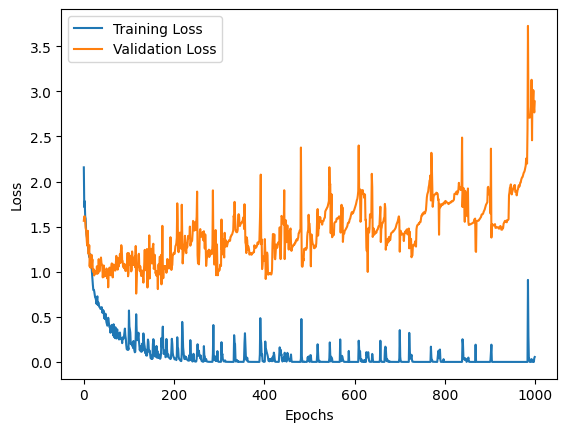

In [197]:
# Plotting train and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [199]:
# Test loop for accuracy
#dataset.set_epoch(0)
correct = 0
total = 0
with torch.no_grad():
    for skeletons, labels in test_loader:
        skeletons, labels = skeletons.to(device), labels.to(device)

        #print(skeletons)
        #print(labels)
        try:
            outputs = model(skeletons)
            #print(outputs)

            _, predicted = torch.max(outputs.data, 1)
           #print(predicted)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        except Exception as e:
            print(e)


accuracy = 100 * correct / total
print(f'Accuracy on test set: {accuracy}%')

Accuracy on test set: 86.66666666666667%
